# West Nile Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('../data/trainw.csv')
test  = pd.read_csv('../data/testw.csv')
train.columns = [col.lower().replace(' ', '_') for col in train.columns]
test.columns = [col.lower().replace(' ', '_') for col in test.columns]

                    

In [3]:
test.columns

Index(['unnamed:_0', 'index', 'id', 'date', 'address', 'block', 'street',
       'trap', 'addressnumberandstreet', 'latitude', 'longitude',
       'addressaccuracy', 'year', 'month', 'day', 'tmax_x', 'tmin_x', 'tavg_x',
       'depart_x', 'dewpoint_x', 'wetbulb_x', 'heat_x', 'cool_x', 'sunrise_x',
       'sunset_x', 'codesum_x', 'depth_x', 'water1_x', 'snowfall_x',
       'preciptotal_x', 'stnpressure_x', 'sealevel_x', 'resultspeed_x',
       'resultdir_x', 'avgspeed_x', 'tmax_y', 'tmin_y', 'tavg_y', 'depart_y',
       'dewpoint_y', 'wetbulb_y', 'heat_y', 'cool_y', 'sunrise_y', 'sunset_y',
       'codesum_y', 'depth_y', 'water1_y', 'snowfall_y', 'preciptotal_y',
       'stnpressure_y', 'sealevel_y', 'resultspeed_y', 'resultdir_y',
       'avgspeed_y', 'species_culex_pipiens', 'species_culex_pipiens/restuans',
       'species_culex_restuans', 'species_culex_salinarius',
       'species_culex_tarsalis', 'species_culex_territans',
       'species_unspecified_culex', 'distance', 'dist_spec

In [4]:
train.columns

Index(['unnamed:_0', 'address', 'addressaccuracy', 'addressnumberandstreet',
       'avgspeed_x', 'avgspeed_y', 'block', 'codesum_x', 'codesum_y', 'cool_x',
       'cool_y', 'date', 'day', 'depart_x', 'depart_y', 'depth_x', 'depth_y',
       'dewpoint_x', 'dewpoint_y', 'distance', 'heat_x', 'heat_y', 'index',
       'latitude', 'longitude', 'month', 'nummosquitos', 'preciptotal_x',
       'preciptotal_y', 'resultdir_x', 'resultdir_y', 'resultspeed_x',
       'resultspeed_y', 'sealevel_x', 'sealevel_y', 'snowfall_x', 'snowfall_y',
       'species_culex_pipiens', 'species_culex_pipiens/restuans',
       'species_culex_restuans', 'species_culex_salinarius',
       'species_culex_tarsalis', 'species_culex_territans', 'stnpressure_x',
       'stnpressure_y', 'street', 'sunrise_x', 'sunrise_y', 'sunset_x',
       'sunset_y', 'tavg_x', 'tavg_y', 'tmax_x', 'tmax_y', 'tmin_x', 'tmin_y',
       'trap', 'water1_x', 'water1_y', 'wetbulb_x', 'wetbulb_y', 'wnvpresent',
       'year', 'dist_species_c

In [5]:
#included features
features = [ 'trap', 'block', 'day', 'month',
            'species_culex_pipiens', 'species_culex_pipiens/restuans',
            'species_culex_restuans', 'species_culex_salinarius',
            'species_culex_tarsalis', 'species_culex_territans', 'wetbulb_y', 
            'tmax_y', 'distance', 'dist_species_culex_pipiens',
            'dist_species_culex_pipiens/restuans', 'dist_species_culex_restuans',
            'dist_species_culex_salinarius', 'dist_species_culex_tarsalis',
            'dist_species_culex_territans']

X = train[features]
y = train['wnvpresent']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 6, stratify = y)

In [7]:
X_train.head().T

,10477,1929,6,3078,3279
trap,102.000000,13.000000,46.000000,11.000000,60.000000
block,10.000000,61.000000,25.000000,36.000000,22.000000
day,26.000000,15.000000,29.000000,12.000000,18.000000
month,9.000000,8.000000,5.000000,9.000000,9.000000
species_culex_pipiens,0.000000,1.000000,0.000000,0.000000,0.000000
species_culex_pipiens/restuans,0.000000,0.000000,0.000000,1.000000,1.000000
species_culex_restuans,1.000000,0.000000,1.000000,0.000000,0.000000
species_culex_salinarius,0.000000,0.000000,0.000000,0.000000,0.000000
species_culex_tarsalis,0.000000,0.000000,0.000000,0.000000,0.000000
species_culex_territans,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
datasets = (X_train, y_train)
traincombined = pd.concat(datasets, axis = 1)
traincombined.head()

,trap,block,day,month,species_culex_pipiens,species_culex_pipiens/restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,wetbulb_y,tmax_y,distance,dist_species_culex_pipiens,dist_species_culex_pipiens/restuans,dist_species_culex_restuans,dist_species_culex_salinarius,dist_species_culex_tarsalis,dist_species_culex_territans,wnvpresent
10477,102,10,26.0,9.0,0,0,1,0,0,0,58,75,0.488413,0.000000,0.000000,0.488413,0.0,0.0,0.0,0.0
1929,13,61,15.0,8.0,1,0,0,0,0,0,71,81,0.539636,0.539636,0.000000,0.000000,0.0,0.0,0.0,0.0
6,46,25,29.0,5.0,0,0,1,0,0,0,66,88,0.358443,0.000000,0.000000,0.358443,0.0,0.0,0.0,0.0
3078,11,36,12.0,9.0,0,1,0,0,0,0,50,66,1.771727,0.000000,1.771727,0.000000,0.0,0.0,0.0,1.0
3279,60,22,18.0,9.0,0,1,0,0,0,0,65,89,0.622362,0.000000,0.622362,0.000000,0.0,0.0,0.0,0.0


In [9]:
west_nile = traincombined[traincombined.wnvpresent == 1]

In [10]:
extra_west_nile = west_nile.sample(n = 5000, replace = True, random_state = 63, axis = 0)

In [11]:
merge = [traincombined, extra_west_nile]
traincombined = pd.concat(merge, axis = 0)

In [12]:
traincombined.shape

(12879, 20)

In [13]:
traincombined.corr()

,trap,block,day,month,species_culex_pipiens,species_culex_pipiens/restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,wetbulb_y,tmax_y,distance,dist_species_culex_pipiens,dist_species_culex_pipiens/restuans,dist_species_culex_restuans,dist_species_culex_salinarius,dist_species_culex_tarsalis,dist_species_culex_territans,wnvpresent
trap,1.000000,-0.366928,0.055994,-0.056089,-0.092077,0.066231,0.032452,0.001477,-0.004490,-0.026831,-0.054215,-0.001669,0.239564,-0.009229,0.156444,0.072445,0.007136,-0.004767,-0.022404,0.097109
block,-0.366928,1.000000,-0.017376,0.011597,-0.041489,0.038784,-0.001014,-0.006264,-0.001506,0.008825,-0.016363,-0.027312,-0.090224,-0.036543,-0.037503,-0.015248,-0.008027,0.001645,0.004396,0.014945
day,0.055994,-0.017376,1.000000,-0.264738,-0.018522,0.000853,0.020217,-0.010090,0.011589,0.007529,0.079533,-0.072288,0.096467,0.006733,0.048437,0.033833,-0.002314,0.011912,0.008812,0.008316
month,-0.056089,0.011597,-0.264738,1.000000,0.255032,0.009221,-0.312506,-0.017877,0.013055,0.001658,-0.042550,-0.010833,-0.152584,0.191888,-0.049448,-0.273796,-0.027393,0.013744,-0.013376,0.252294
species_culex_pipiens,-0.092077,-0.041489,-0.018522,0.255032,1.000000,-0.646863,-0.338064,-0.045736,-0.010564,-0.078113,0.140113,0.066304,-0.167452,0.842751,-0.514810,-0.290456,-0.039382,-0.009734,-0.070025,0.196968
species_culex_pipiens/restuans,0.066231,0.038784,0.000853,0.009221,-0.646863,1.000000,-0.456552,-0.061766,-0.014267,-0.105491,-0.057120,-0.022955,0.068515,-0.545145,0.795856,-0.392257,-0.053185,-0.013146,-0.094568,0.026525
species_culex_restuans,0.032452,-0.001014,0.020217,-0.312506,-0.338064,-0.456552,1.000000,-0.032280,-0.007456,-0.055132,-0.096811,-0.056254,0.109178,-0.284904,-0.363350,0.859174,-0.027795,-0.006870,-0.049423,-0.230050
species_culex_salinarius,0.001477,-0.006264,-0.010090,-0.017877,-0.045736,-0.061766,-0.032280,1.000000,-0.001009,-0.007459,-0.007041,-0.005511,0.001262,-0.038544,-0.049157,-0.027734,0.861064,-0.000929,-0.006686,-0.056270
species_culex_tarsalis,-0.004490,-0.001506,0.011589,0.013055,-0.010564,-0.014267,-0.007456,-0.001009,1.000000,-0.001723,-0.020642,-0.024813,0.018884,-0.008903,-0.011354,-0.006406,-0.000869,0.921428,-0.001544,-0.012997
species_culex_territans,-0.026831,0.008825,0.007529,0.001658,-0.078113,-0.105491,-0.055132,-0.007459,-0.001723,1.000000,0.017245,0.029853,0.006461,-0.065830,-0.083956,-0.047368,-0.006422,-0.001587,0.896452,-0.096104


In [14]:
X_train = traincombined[features]
y_train = traincombined['wnvpresent']

In [15]:

X_train.head().T

,10477,1929,6,3078,3279
trap,102.000000,13.000000,46.000000,11.000000,60.000000
block,10.000000,61.000000,25.000000,36.000000,22.000000
day,26.000000,15.000000,29.000000,12.000000,18.000000
month,9.000000,8.000000,5.000000,9.000000,9.000000
species_culex_pipiens,0.000000,1.000000,0.000000,0.000000,0.000000
species_culex_pipiens/restuans,0.000000,0.000000,0.000000,1.000000,1.000000
species_culex_restuans,1.000000,0.000000,1.000000,0.000000,0.000000
species_culex_salinarius,0.000000,0.000000,0.000000,0.000000,0.000000
species_culex_tarsalis,0.000000,0.000000,0.000000,0.000000,0.000000
species_culex_territans,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators'       : [ 100,150, 200],
    'max_depth'          : [20 , 40, 60 ],
    'min_samples_leaf'   : [ 3, 6 , 9]
}



In [17]:
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
gs.score(X_test, y_test)


0.9378833760385124
{'max_depth': 40, 'min_samples_leaf': 3, 'n_estimators': 100}


0.8972211648267986

In [18]:
y_hat = gs.predict(X_test)
y_hat_train = gs.predict(X_train)
y_hat_prob = gs.predict_proba(X_test)


In [19]:
print(classification_report( y_train, y_hat_train))

             precision    recall  f1-score   support

        0.0       0.98      0.95      0.97      7466
        1.0       0.93      0.98      0.96      5413

avg / total       0.96      0.96      0.96     12879



In [20]:
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

        0.0       0.96      0.93      0.94      2489
        1.0       0.18      0.28      0.22       138

avg / total       0.92      0.90      0.91      2627



In [21]:
confusion_matrix(y_train, y_hat_train)

array([[7095,  371],
       [ 113, 5300]])

In [22]:
confusion_matrix(y_test, y_hat)

array([[2319,  170],
       [ 100,   38]])

In [23]:
X = test[features]
predict = (gs.predict(X))
predprob = gs.predict_proba(X)

In [24]:
predprob

array([[0.97294444, 0.02705556],
       [0.98897181, 0.01102819],
       [0.93439908, 0.06560092],
       ...,
       [0.90825954, 0.09174046],
       [0.90825954, 0.09174046],
       [0.90825954, 0.09174046]])

In [25]:
rf.fit(X_train, y_train)
print(X_train.columns)
rf.feature_importances_

Index(['trap', 'block', 'day', 'month', 'species_culex_pipiens',
       'species_culex_pipiens/restuans', 'species_culex_restuans',
       'species_culex_salinarius', 'species_culex_tarsalis',
       'species_culex_territans', 'wetbulb_y', 'tmax_y', 'distance',
       'dist_species_culex_pipiens', 'dist_species_culex_pipiens/restuans',
       'dist_species_culex_restuans', 'dist_species_culex_salinarius',
       'dist_species_culex_tarsalis', 'dist_species_culex_territans'],
      dtype='object')


array([0.15198239, 0.10699885, 0.09695493, 0.12965685, 0.00667946,
       0.00537111, 0.01757391, 0.00082055, 0.        , 0.00210004,
       0.10131655, 0.1035222 , 0.1164636 , 0.05700747, 0.06899822,
       0.02958811, 0.00070466, 0.        , 0.00426112])

In [26]:
knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors' : [7, 9, 11],
    'weights'      : ['uniform','distance']
}

gs = GridSearchCV(knn, param_grid=knn_params)
gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)
print(gs.score(X_test,y_test))
y_hat = gs.predict(X_test)
y_hat_train = gs.predict(X_train)
print(classification_report(y_test, y_hat))

{'n_neighbors': 7, 'weights': 'distance'}
0.8784067085953878
0.8287019413779977
             precision    recall  f1-score   support

        0.0       0.96      0.85      0.90      2489
        1.0       0.12      0.38      0.19       138

avg / total       0.92      0.83      0.87      2627



In [27]:
predict_knn = gs.predict(X)

In [28]:
lr = LogisticRegressionCV(Cs= [1., 1, 10])
lr.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1.0, 1, 10], class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [29]:
y_lrp = lr.predict_proba(X_test)
y_lr = lr.predict(X_test)
lr.score(X_test,y_test)

0.7110772744575562

In [30]:
X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label'] = y_lr
X_test.loc[:, 'predicted_proba'] = y_lrp[:, 1]

In [31]:
# Generate False positive rate and True positive rate
fpr, tpr, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc = auc(fpr, tpr)

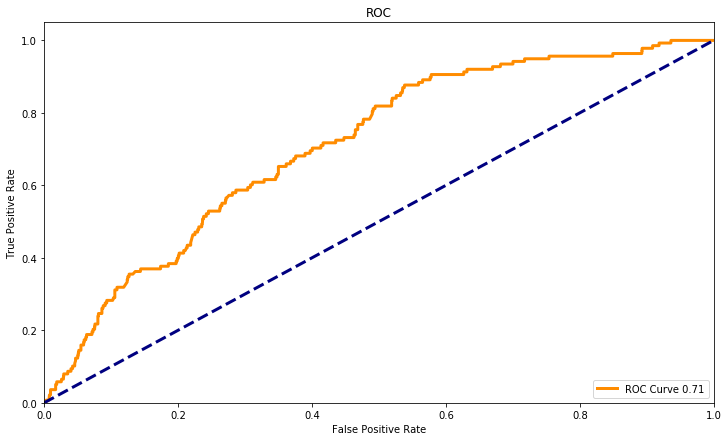

In [32]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [33]:
lr_predict = lr.predict(X)
lr_proba = lr.predict_proba(X)[:,1]

In [34]:
lr_proba

array([0.20288616, 0.08691287, 0.22822991, ..., 0.78058053, 0.7906358 ,
       0.7906358 ])

In [35]:
submissions = pd.DataFrame(lr_predict, columns = ['wnvpresent'])
submissions['predproba'] = lr_proba
submissions.loc[:, 'wnvpresent']= submissions['predproba'].map(
    lambda p: 1 if p > .6 else 0)

In [36]:
submissions.wnvpresent.value_counts()

0    109904
1      6389
Name: wnvpresent, dtype: int64

In [37]:
submissions['id'] = [id +1 for id in range(len(submissions))]

In [38]:
submissions = submissions[['id','wnvpresent' ]]


In [39]:
submissions.to_csv('../data/submission.csv', index = False)